### Boosted Tree Classification Model
In this tutorial, we show you the steps to train a boosted tree classification model, and also how to evaluate this model afterwards.

### 1. Import libraries
First of all, we import xgboost, the library which provides boosted tree functionality. The purpose other libraries will be explained as we advance in the tutorial.

In [2]:
import math
import json
import xgboost
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

### 2. Load data
We use Pandas to load the preprocessed version of our dataset (london_clean.csv) and select only the columns we will use for training the tree. We are aware the unecessary columns could have been removed in the preprocessing phase, but we chose to keep them in the file so we can experiment with different combination of inputs/outputs.

In [3]:
ds = pd.read_csv('preprocessing/data/london_clean.csv')
selected_cols = ["DateOfCall", "PropertyType", "NumPumpsAttending", 
                    "PumpHoursRoundUp", "CostCat", "mean_temp"]
ds = ds.loc[:, selected_cols]

### 3. Split data
After loading the data, we start by splitting the dataset between columns that will be used as input to train the model (X) and the actual output (y). In other words, for a certain combination of data about the file (e.g. data of call, property type, etc.) we want to predict its cost category.

Besides splitting columns, we also want to split the rows to create two datasets: one for training (70% of the original dataset rows) and testing (30% of the original dataset rows). We use train_test_split from scikit-learn to do this task for us.

In [4]:
X = ds.drop(["CostCat"], axis=1).values 
y = ds["CostCat"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, test_size=0.3, random_state=42
)

### 4. Train model
We call xgboost.XGBClassifier and use the training dataset (x_train, y_train) to train the model. We use the hyperparameter objective="multi:softmax" because we want to do multiclass classification. We keep the other hyperparameters in their default values. Later, in step 6, we will try different hyperparameter combinations to find the best one.

In [12]:
model = xgboost.XGBClassifier(objective="multi:softmax", random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [16]:
#model.get_params() 
print(model.tree_)

AttributeError: 'XGBClassifier' object has no attribute 'tree_'

### 5. Make predictions
We use the trained model to make predictions. We then compare these predictions to the actual labels to check how accurate is the model. According to sci-kit learn's classification_report, the accuracy (average f1-score) is 0.77.

In [9]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.90      0.82    210199
           1       0.76      0.48      0.59    127674
           2       1.00      1.00      1.00     31404
           3       0.70      0.91      0.79      4963
           4       0.72      0.42      0.53      4546
           5       0.91      0.96      0.93      7200

    accuracy                           0.77    385986
   macro avg       0.80      0.78      0.78    385986
weighted avg       0.77      0.77      0.75    385986



### 6. Hyperparameter tunning
ATTENTION: the code below may take a long time to run and consume a large amount of CPU/RAM from your system.

We used GridSearchCV to search for the best combination of hyperparameters for training a boosted tree. After the search is done, we convert the cv_results_ object into a JSON file, which we used to create the visualizations seen in step 7. 

GridSearchCV will also do cross-validation (here we used 5 splits).

We ran the search for the following hyperparameters: number of estimators (trees), max depth, tree method and booster. Due to limitations of CPU/RAM on our laptops, we ran the search below in parts. 
1. We searched for the best n_estimators. 
2. We then used the best value found for n_estimators and ran the search for max_depth and tree_method. 
3. Finally, we used the best values found for n_estimators, max_depth and tree_method and ran the search for booster.

You can see the results we obtained on step 7.

In [7]:
tree_params = {'n_estimators': [50, 100, 200, 300], 
               'max_depth': [10, 50, 100], 
               'tree_method': ['exact', 'approx', 'hist']}
model_best = GridSearchCV(xgboost.XGBClassifier(), tree_params, n_jobs=4, cv=5)
model_best = model_best.fit(X_train, y_train)

f = open('test_results/gridsearchcv_results.json', 'w+')
f.write(json.dumps(model_best.cv_results_))
f.close()

### 7. Analysing results of the hyperparameter tunning
At first, we compare the test score and fit time for the n_estimators hyperparameter. The best is n_estimators=300. There is a difference of 0.05 between the worst option (50) to the best (300). 

In contrast, there is a difference of 0.005 between the top 2 options (300 and 200). Therefore, we decided to stop the search in 300, since we seem to have reached the maximum improvement for this hyperparameter. Also, the time and resources necessary to search with higher values also increase, making the search inviable.

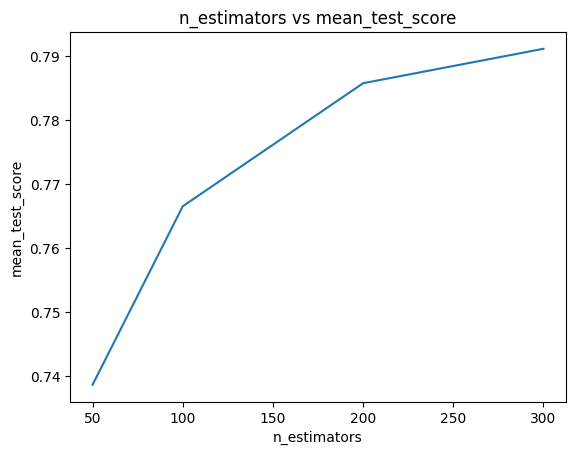

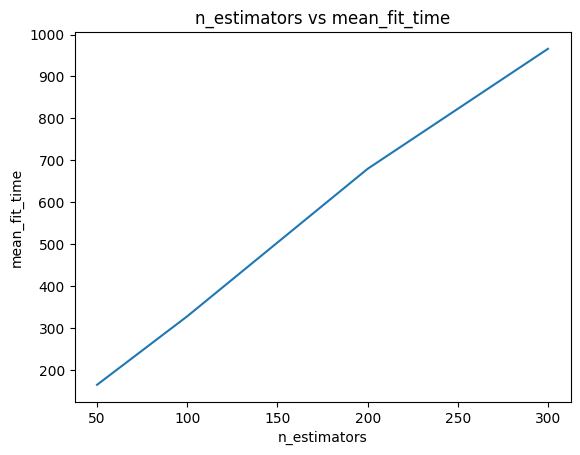

In [11]:
def getHyperRankPair(rank):
    posOfRank = ranks.index(rank)
    return results["param_n_estimators"][posOfRank]

def getStatForRank(results, ranks, rank, stat):
    posOfRank = ranks.index(rank)
    return results[stat][posOfRank]

def drawChart(title, xaxis, yaxis, xlabel, ylabel):
    plt.plot(xaxis, yaxis)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

n_estims_rank = [50, 100, 200, 300]
file = open('test_results/gridsearchcv_results.json')
results = json.load(file)
ranks = results['rank_test_score']

all_pairs = {}
axis_mean_fit_time = []
axis_mean_test_score = []
for i in range(1, 5):
    all_pairs[i] = getHyperRankPair(i)
    axis_mean_fit_time.append(getStatForRank(results, ranks, i, "mean_fit_time"))
    axis_mean_test_score.append(getStatForRank(results, ranks, i, "mean_test_score"))

drawChart('n_estimators vs mean_test_score', list(all_pairs.values()), axis_mean_test_score, 'n_estimators', 'mean_test_score')
drawChart('n_estimators vs mean_fit_time', list(all_pairs.values()), axis_mean_fit_time, 'n_estimators', 'mean_fit_time')

Then, we compare the test score and fit time for the hyperparameters: max_depth and tree_method. The best is X. The fastest is Y.

In [ ]:
n_estims_rank = [50, 100, 200, 300]
file = open('test_results/gridsearchcv_results.json')
results = json.load(file)
ranks = results['rank_test_score']

all_pairs = {}
axis_mean_fit_time = []
axis_mean_test_score = []
for i in range(1, 5):
    all_pairs[i] = getHyperRankPair(i)
    axis_mean_fit_time.append(getStatForRank(results, ranks, i, "mean_fit_time"))
    axis_mean_test_score.append(getStatForRank(results, ranks, i, "mean_test_score"))

drawChart('n_estimators vs mean_test_score', list(all_pairs.values()), axis_mean_test_score, 'n_estimators', 'mean_test_score')
drawChart('n_estimators vs mean_fit_time', list(all_pairs.values()), axis_mean_fit_time, 'n_estimators', 'mean_fit_time')

Finally, we compare the test score and fit time for the booster hyperparameter. The best is X. The fastest is Y.

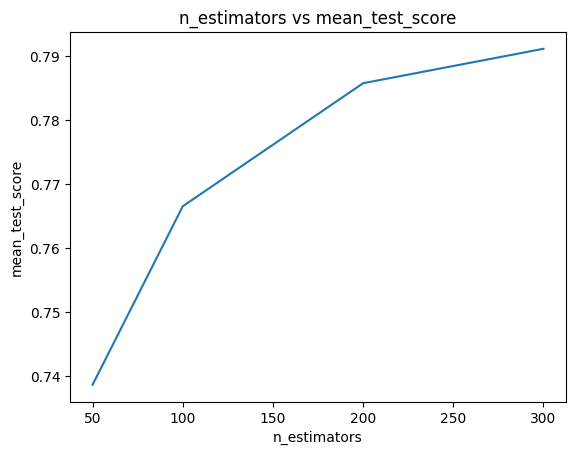

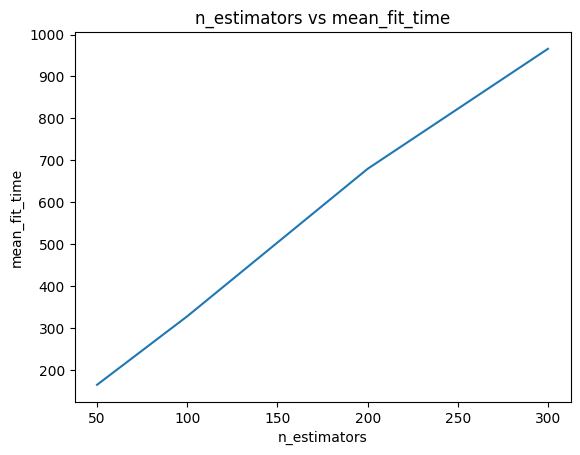

In [12]:
n_estims_rank = [50, 100, 200, 300]
file = open('test_results/gridsearchcv_results.json')
results = json.load(file)
ranks = results['rank_test_score']

all_pairs = {}
axis_mean_fit_time = []
axis_mean_test_score = []
for i in range(1, 5):
    all_pairs[i] = getHyperRankPair(i)
    axis_mean_fit_time.append(getStatForRank(results, ranks, i, "mean_fit_time"))
    axis_mean_test_score.append(getStatForRank(results, ranks, i, "mean_test_score"))

drawChart('n_estimators vs mean_test_score', list(all_pairs.values()), axis_mean_test_score, 'n_estimators', 'mean_test_score')
drawChart('n_estimators vs mean_fit_time', list(all_pairs.values()), axis_mean_fit_time, 'n_estimators', 'mean_fit_time')

### 8. Cross Validation
While GridSearchCV already ran cross-validation, we ran it again testing different folds to make sure the accuracy results are not being influenced by a given split of the data. We concluded that X.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

folds = [5, 10]
for i in folds:
    cross_val = KFold(n_splits=i, random_state=42, shuffle=True)
    scores = cross_val_score(model_best, X, y, scoring='accuracy', cv=cross_val, n_jobs=4)
    print("Testing with {} fold:".format(i))
    print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))